In [10]:
# Load the 2015 sales data and create a small feature list
import numpy as np
import geopandas as gpd

stp_sales_2015 = gpd.read_file('./data/parcels/stpete_sales_2015.shp')
stp_sales_2015["x"] = stp_sales_2015.centroid.map(lambda p: p.x)
stp_sales_2015["y"] = stp_sales_2015.centroid.map(lambda p: p.y)
stp_sales_2015_x = stp_sales_2015[['AVE_FAM_SZ', 'AVE_HH_SZ', 'CentroidX', 'CentroidY', 'HS_PER_AC',
       'MEDFINCOME', 'MEDHHINC', 'MEDOOHVAL', 'MED_AGE', 'PCT_AMERI',
       'PCT_ASIAN', 'PCT_BACHLR', 'PCT_BLACK', 'PCT_DIS20', 'PCT_HAWN',
       'PCT_HISP', 'PCT_MULTI', 'PCT_NOTATA', 'PCT_NOTWEL', 'PCT_OTHER',
       'PCT_POV', 'PCT_R125AB', 'PCT_R50_9', 'PCT_RU1', 'PCT_RU50',
       'PCT_WHITE', 'SHAPE_AREA', 'SHAPE_LEN', 'assessed_v', 'comp_sales', 'effective_',
       'fixtures', 'just_build', 'just_land', 'just_marke', 'just_xf', 
       'lisa', 'living_uni', 'medinc_lag', 'school_tax',
       'special_as', 'square_foo', 'stories',
       'tax_amount', 'taxable_va',
       'tot_effect', 'tot_gross_', 'tot_living',
       'total_livi','x', 'y', 'year_built']]
                                  
stp_sales_2015_x
stp_sales_2015_x.columns.values

array(['AVE_FAM_SZ', 'AVE_HH_SZ', 'CentroidX', 'CentroidY', 'HS_PER_AC',
       'MEDFINCOME', 'MEDHHINC', 'MEDOOHVAL', 'MED_AGE', 'PCT_AMERI',
       'PCT_ASIAN', 'PCT_BACHLR', 'PCT_BLACK', 'PCT_DIS20', 'PCT_HAWN',
       'PCT_HISP', 'PCT_MULTI', 'PCT_NOTATA', 'PCT_NOTWEL', 'PCT_OTHER',
       'PCT_POV', 'PCT_R125AB', 'PCT_R50_9', 'PCT_RU1', 'PCT_RU50',
       'PCT_WHITE', 'SHAPE_AREA', 'SHAPE_LEN', 'assessed_v', 'comp_sales',
       'effective_', 'fixtures', 'just_build', 'just_land', 'just_marke',
       'just_xf', 'lisa', 'living_uni', 'medinc_lag', 'school_tax',
       'special_as', 'square_foo', 'stories', 'tax_amount', 'taxable_va',
       'tot_effect', 'tot_gross_', 'tot_living', 'total_livi', 'x', 'y',
       'year_built'], dtype=object)

In [11]:
# Create an 80/20 training test split
from sklearn.cross_validation import train_test_split
FIGSIZE = (11, 7)
# # split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(stp_sales_2015_x,
                                                    stp_sales_2015['price'],
                                                    test_size=0.2,
                                                    random_state=1)
names = stp_sales_2015_x.columns.values
X_train.columns.values

array(['AVE_FAM_SZ', 'AVE_HH_SZ', 'CentroidX', 'CentroidY', 'HS_PER_AC',
       'MEDFINCOME', 'MEDHHINC', 'MEDOOHVAL', 'MED_AGE', 'PCT_AMERI',
       'PCT_ASIAN', 'PCT_BACHLR', 'PCT_BLACK', 'PCT_DIS20', 'PCT_HAWN',
       'PCT_HISP', 'PCT_MULTI', 'PCT_NOTATA', 'PCT_NOTWEL', 'PCT_OTHER',
       'PCT_POV', 'PCT_R125AB', 'PCT_R50_9', 'PCT_RU1', 'PCT_RU50',
       'PCT_WHITE', 'SHAPE_AREA', 'SHAPE_LEN', 'assessed_v', 'comp_sales',
       'effective_', 'fixtures', 'just_build', 'just_land', 'just_marke',
       'just_xf', 'lisa', 'living_uni', 'medinc_lag', 'school_tax',
       'special_as', 'square_foo', 'stories', 'tax_amount', 'taxable_va',
       'tot_effect', 'tot_gross_', 'tot_living', 'total_livi', 'x', 'y',
       'year_built'], dtype=object)

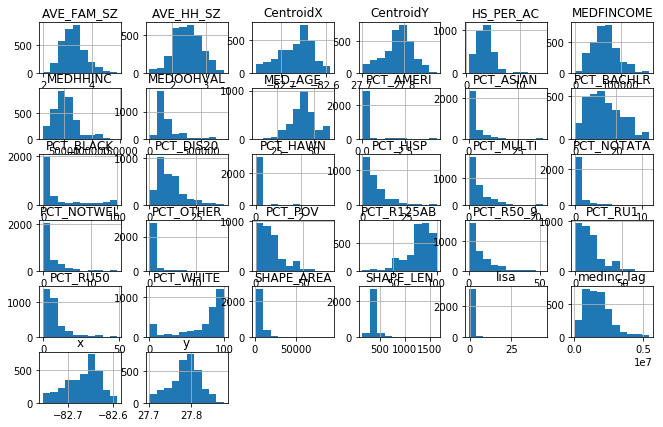

In [12]:
% matplotlib inline
import pandas as pd
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['price'] = y_train
_ = X_df.hist(figsize=FIGSIZE)

In [13]:
# Create a GBM regressor and compare to other models
import time
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR

res = defaultdict(dict)

def benchmark(est, name=None):
    if not name:
        name = est.__class__.__name__
    t0 = time.clock()
    est.fit(X_train, y_train)
    res[name]['train_time'] = time.clock() - t0
    t0 = time.clock()
    pred = est.predict(X_test)
    res[name]['test_time'] = time.clock() - t0
    res[name]['MAE'] = mean_absolute_error(y_test, pred)
    return est
    
benchmark(DummyRegressor())
benchmark(Ridge(alpha=0.0001, normalize=True))
benchmark(Pipeline([('std', StandardScaler()), 
                    ('svr', SVR(kernel='rbf', C=10.0, gamma=0.1, tol=0.001))]), name='SVR')
benchmark(RandomForestRegressor(n_estimators=100, max_features=5, random_state=0, 
                                bootstrap=False, n_jobs=4))
est = benchmark(GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.1,
                                          loss='huber', min_samples_leaf=3, 
                                          random_state=0))

res_df = pd.DataFrame(data=res).T
res_df[['train_time', 'test_time', 'MAE']].sort('MAE', ascending=False)

/home/tankofvines/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,train_time,test_time,MAE
DummyRegressor,0.001577,0.004043,126885.014194
SVR,2.041050,0.177587,112125.204440
Ridge,0.026042,0.025578,32110.876330
RandomForestRegressor,2.015170,0.044858,27049.629899
GradientBoostingRegressor,5.760923,0.009710,21939.713428


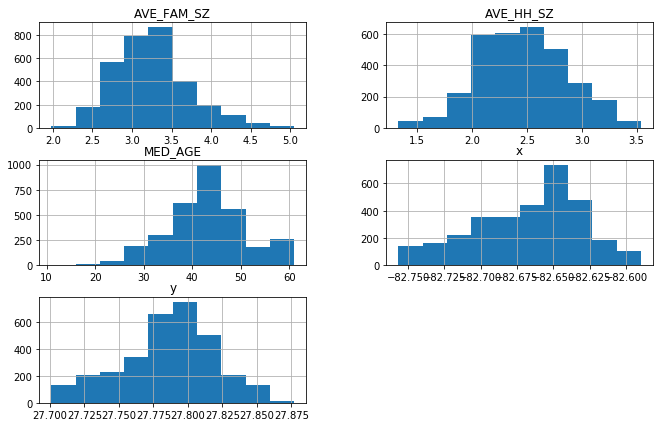

In [14]:
# plot histograms of target and features
% matplotlib inline
import pandas as pd
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['price'] = y_train
_ = X_df.hist(column=['AVE_FAM_SZ', 'AVE_HH_SZ', 'MED_AGE', 'x', 'y'], figsize=FIGSIZE)

/home/tankofvines/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


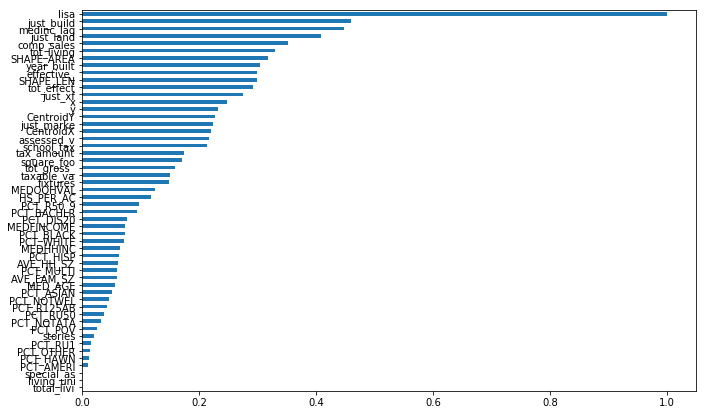

In [15]:
# Plot feature impact
fx_imp = pd.Series(est.feature_importances_, index=names)
fx_imp /= fx_imp.max()  # normalize
fx_imp.sort()
fx_imp.plot(kind='barh', figsize=FIGSIZE)

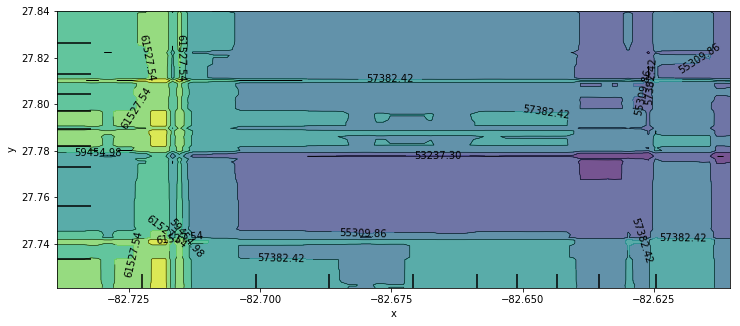

In [18]:
# 1 way and 2 way partial dependence for features
from sklearn.ensemble.partial_dependence import plot_partial_dependence

features = [('x', 'y')]
fig, axs = plot_partial_dependence(est, X_train, features, feature_names=names, 
                                   n_cols=2, figsize=FIGSIZE)